# 웹 검색 기반 주식 투자 챗봇

## 학습 목표
이 노트북에서는 다음 내용을 배웁니다:
- LangGraph의 조건부 엣지(Conditional Edge) 사용법
- Tavily 웹 검색 API 활용
- State 기반 반복 제어 (최대 반복 횟수)
- Context 누적 및 평가 기반 의사결정
- Pydantic을 사용한 구조화된 출력

## 주요 개선사항
- LLM 모델명: gpt-4o-mini
- 평가 로직: 낮은 점수일 때 웹 검색 수행
- Context 누적: 기존 검색 결과에 새 결과 추가 (덮어쓰지 않음)
- 무한 루프 방지: 최대 반복 횟수 제한
- 에러 처리: 각 노드에서 예외 처리

## 1. 환경 변수 로드

### 이론
`.env` 파일에서 API 키를 안전하게 로드합니다.
- `OPENAI_API_KEY`: OpenAI API 사용을 위한 키
- `TAVILY_API_KEY`: Tavily 검색 API 사용을 위한 키

### 코드 설명
- `load_dotenv()`: `.env` 파일에서 환경 변수 읽기

In [1]:
# 환경 변수 로드
from dotenv import load_dotenv

load_dotenv()

True

## 2. LLM 초기화

### 이론
**Temperature** 파라미터:
- `temperature=0`: 결정적(deterministic) 출력, 항상 같은 답변
- 높을수록 창의적이지만 일관성이 떨어짐
- 평가와 같은 작업에는 0이 적합

### 코드 설명
- `ChatOpenAI(model="gpt-4o-mini", temperature=0)`: 일관된 답변을 위한 LLM 설정

In [2]:
# LLM 초기화 (수정: gpt-4o-mini로 변경)
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

## 3. AgentState 정의

### 이론
**확장된 State 구조**:
이 노트북의 State는 더 복잡합니다:
- `query`: 사용자 질문 (변하지 않음)
- `context`: **웹 검색 결과를 누적하는 리스트**
- `answer`: 생성된 답변
- `search_threshold`: 검색 트리거 기준 점수 (이 점수 이하면 검색)
- `iteration_count`: 현재 반복 횟수
- `max_iterations`: 최대 반복 횟수 (무한 루프 방지)
- `evaluation_score`: 답변 평가 점수
- `evaluation_comment`: 평가 코멘트
- `error`: 에러 메시지

**반복 제어 메커니즘**:
- `iteration_count`가 `max_iterations`에 도달하면 강제 종료
- `search_threshold`로 답변 품질 판단

### 코드 설명
- `TypedDict`: 각 필드에 타입 지정
- `StateGraph(AgentState)`: 이 State를 사용하는 그래프 생성

In [3]:
# State 정의 (개선: 메타데이터 추가)
from typing_extensions import TypedDict
from typing import List, Dict, Any
from langgraph.graph import StateGraph


class AgentState(TypedDict):
    query: str                    # 사용자 질문
    context: List[Dict[str, Any]] # 웹 검색 결과 누적 리스트
    answer: str                   # 생성된 답변
    search_threshold: int         # 웹 검색 트리거 기준 점수 (이하면 검색)
    iteration_count: int          # 현재 반복 횟수
    max_iterations: int           # 최대 반복 횟수
    evaluation_score: int         # 마지막 평가 점수
    evaluation_comment: str       # 평가 코멘트
    error: str                    # 에러 메시지


graph_builder = StateGraph(AgentState)

## 4. Generate 노드 (답변 생성)

### 이론
**두 가지 프롬프트 전략**:
1. `context_prompt`: 웹 검색 결과가 있을 때
   - 검색 자료를 활용하여 구체적인 답변 생성
   - 출처 명시, 수치와 날짜 포함
2. `simple_prompt`: 검색 결과가 없을 때
   - 일반 지식으로 답변
   - 실시간 데이터가 필요함을 명시

**Pydantic 구조화된 출력**:
- `AnswerOutput` 클래스로 답변 구조 정의
- `answer`, `confidence`, `sources_used` 필드
- 현재는 사용하지 않지만 확장 가능성 제공

### 코드 설명
- `state.get("context", [])`: context가 없으면 빈 리스트 반환
- `if context and len(context) > 0`: context 유무에 따라 다른 프롬프트 사용
- `formatted_context`: 검색 결과를 읽기 좋게 포맷팅
- `chain = prompt | llm | StrOutputParser()`: LCEL (LangChain Expression Language) 체인
- `return {"answer": response, "iteration_count": iteration + 1}`: 답변 저장 및 반복 횟수 증가
- `try-except`: 에러 발생 시 에러 메시지 저장

In [4]:
# Generate 노드 (개선: 구조화된 출력, 에러 처리)
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field


class AnswerOutput(BaseModel):
    """구조화된 답변 출력"""
    answer: str = Field(description="사용자 질문에 대한 상세한 답변")
    confidence: str = Field(description="답변 신뢰도: high/medium/low")
    sources_used: bool = Field(description="웹 검색 결과를 사용했는지 여부")


# Context가 있을 때 사용하는 프롬프트
context_prompt = PromptTemplate.from_template("""
당신은 주식 투자 전문가입니다. 주어진 웹 검색 자료(context)에 기반하여 질문(question)에 대한 답을 제공하세요.

검색 자료:
{context}

질문: {query}

답변 작성 지침:
1. 검색 자료의 정보를 정확히 인용하세요
2. 구체적인 수치와 날짜를 포함하세요
3. 출처가 명확하지 않은 추측은 피하세요
4. 간결하고 명확하게 작성하세요
""")

# Context가 없을 때 사용하는 프롬프트
simple_prompt = PromptTemplate.from_template("""
당신은 주식 투자 전문가입니다. 다음 질문에 답변하세요.

질문: {query}

답변 작성 지침:
1. 일반적인 투자 원칙과 지식을 바탕으로 답변하세요
2. 실시간 데이터가 필요한 경우 그 점을 명시하세요
3. 간결하고 명확하게 작성하세요
""")


def generate(state: AgentState) -> AgentState:
    """
    답변을 생성하는 노드
    - Context가 있으면 이를 활용하여 답변 생성
    - Context가 없으면 일반 지식으로 답변
    - 에러 발생 시 에러 메시지 저장
    """
    try:
        query = state["query"]
        context = state.get("context", [])
        iteration = state.get("iteration_count", 0)
        
        print(f"\n{'='*50}")
        print(f"[Generate] Iteration {iteration + 1}")
        print(f"Context 개수: {len(context)}")
        
        if context and len(context) > 0:
            # Context를 보기 좋게 포맷팅
            formatted_context = "\n\n".join([
                f"[출처 {i+1}]\n제목: {item.get('title', 'N/A')}\n내용: {item.get('content', item.get('raw_content', 'N/A')[:500])}\nURL: {item.get('url', 'N/A')}"
                for i, item in enumerate(context)
            ])
            
            chain = context_prompt | llm | StrOutputParser()
            response = chain.invoke({"context": formatted_context, "query": query})
            return {
                "answer": response,
                "iteration_count": iteration + 1
            }
        else:
            chain = simple_prompt | llm | StrOutputParser()
            response = chain.invoke({"query": query})
            return {
                "answer": response,
                "iteration_count": iteration + 1
            }
            
    except Exception as e:
        error_msg = f"Generate 함수 에러: {str(e)}"
        print(f"❌ {error_msg}")
        return {
            "error": error_msg,
            "answer": "답변 생성 중 오류가 발생했습니다."
        }

## 5. QA 평가 노드

### 이론
**평가 기준 (20점 만점)**:
1. 정확성 (0-5점): 답변이 질문에 정확히 답하는가?
2. 완전성 (0-5점): 답변이 충분히 상세한가?
3. 명확성 (0-5점): 답변이 이해하기 쉬운가?
4. 관련성 (0-5점): 답변이 질문과 관련이 있는가?

**조건부 라우팅**:
- `'enough'`: 점수 >= threshold이고 추가 정보 불필요 → 종료
- `'search'`: 점수 < threshold이거나 추가 정보 필요 → 웹 검색
- `'max_reached'`: 최대 반복 횟수 도달 → 강제 종료

**Pydantic Structured Output**:
- `EvaledAnswer` 클래스로 평가 결과 구조화
- `score`, `comment`, `needs_more_info` 필드
- `with_structured_output()`: LLM이 이 구조로 응답하도록 강제

### 코드 설명
- `Literal['enough', 'search', 'max_reached']`: 반환 가능한 값 제한
- `structured_qa_eval_llm = ChatOpenAI(...).with_structured_output(EvaledAnswer)`: 구조화된 출력 LLM
- `if state.get("error")`: 에러가 있으면 즉시 종료
- `if iteration >= max_iterations`: 최대 반복 도달 체크
- `if score >= search_threshold and not needs_more_info`: 충분한 답변 판단
- `return 'search'`: 점수 낮거나 추가 정보 필요 시 검색

In [5]:
# QA 평가 노드 (개선: 로직 수정 - 낮은 점수일 때 검색)
from typing import Literal


class EvaledAnswer(BaseModel):
    """답변 평가 결과"""
    score: int = Field(..., ge=0, le=20, description="각 기준별 점수를 합한 합산 점수 (0-20)")
    comment: str = Field(description="평가기준에 따른 상세 코멘트")
    needs_more_info: bool = Field(description="더 많은 정보가 필요한지 여부")


qa_eval_prompt = PromptTemplate(
    input_variables=["question", "answer"],
    template="""
다음 질문과 답변을 평가해주세요:

질문: {question}
답변: {answer}

평가 기준 (각 0-5점, 총 20점):
1. 정확성 (0-5점): 답변이 질문에 정확히 답하고 있는가?
2. 완전성 (0-5점): 답변이 충분히 상세하고 완전한가?
3. 명확성 (0-5점): 답변이 이해하기 쉽고 명확한가?
4. 관련성 (0-5점): 답변이 질문과 관련이 있는가?

평가 시 고려사항:
- 구체적인 수치, 날짜, 출처가 포함되어 있는가?
- "인터넷 검색이 필요하다", "확인할 수 없다" 등의 답변은 낮은 점수
- 실시간 주가, 최신 뉴스 등이 필요한 경우 needs_more_info를 true로 설정

각 기준에 대해 점수를 매기고, 평가 기준별 점수를 모두 더한 합산 점수(0-20)와 개선사항을 제시하세요.
"""  
)

structured_qa_eval_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0).with_structured_output(EvaledAnswer)


def qa_eval(state: AgentState) -> Literal['enough', 'search', 'max_reached']:
    """
    답변 품질을 평가하는 노드
    
    로직 개선:
    - 점수가 threshold 이상이면 'enough' (종료)
    - 점수가 threshold 미만이면 'search' (웹 검색)
    - max_iterations 도달하면 'max_reached' (강제 종료)
    """
    try:
        answer = state["answer"]
        query = state["query"]
        iteration = state.get("iteration_count", 0)
        search_threshold = state.get("search_threshold", 15)
        max_iterations = state.get("max_iterations", 3)
        
        # 에러가 있으면 즉시 종료
        if state.get("error"):
            return 'max_reached'
        
        eval_chain = qa_eval_prompt | structured_qa_eval_llm
        response = eval_chain.invoke({"answer": answer, "question": query})
        
        score = response.score
        comment = response.comment
        needs_more_info = response.needs_more_info
        
        print(f"\n[QA Eval] Iteration {iteration}")
        print(f"평가 점수: {score}/20")
        print(f"코멘트: {comment}")
        print(f"추가 정보 필요: {needs_more_info}")
        
        # State 업데이트
        state["evaluation_score"] = score
        state["evaluation_comment"] = comment
        
        # 최대 반복 횟수 도달 체크
        if iteration >= max_iterations:
            print(f"⚠️ 최대 반복 횟수({max_iterations}) 도달. 종료합니다.")
            return 'max_reached'
        
        # 점수가 threshold 이상이고 추가 정보 불필요하면 종료
        if score >= search_threshold and not needs_more_info:
            print(f"✅ 점수가 threshold({search_threshold}) 이상입니다. 종료합니다.")
            return 'enough'
        
        # 점수가 낮거나 추가 정보 필요하면 웹 검색
        print(f"🔍 점수가 낮거나 추가 정보가 필요합니다. 웹 검색을 실행합니다.")
        return 'search'
        
    except Exception as e:
        error_msg = f"QA Eval 함수 에러: {str(e)}"
        print(f"❌ {error_msg}")
        state["error"] = error_msg
        return 'max_reached'

## 6. 웹 검색 노드

### 이론
**Tavily Search API**:
- 실시간 웹 검색 엔진
- `max_results=3`: 최대 3개 결과
- `search_depth="advanced"`: 고급 검색 (더 깊은 분석)
- `include_answer=True`: Tavily가 생성한 요약 답변 포함
- `include_raw_content=True`: 원본 콘텐츠 포함
- `include_images=False`: 이미지 제외 (토큰 절약)

**Context 누적 전략**:
- 기존 검색 결과를 **덮어쓰지 않고** 새 결과를 **추가**
- 중복 URL 제거로 동일한 출처 방지
- 반복마다 더 많은 정보 축적

### 코드 설명
- `TavilySearch(...)`: Tavily 검색 도구 초기화
- `existing_context = state.get("context", [])`: 기존 context 가져오기
- `results = tavily_search_tool.invoke(query)`: 웹 검색 실행
- `existing_urls = {item.get('url') for item in existing_context}`: 기존 URL 세트
- `new_results = [result for result in results if result.get('url') not in existing_urls]`: 중복 제거
- `updated_context = existing_context + new_results`: **누적** (덮어쓰기 X)
- `return {"context": updated_context}`: 업데이트된 context 반환

In [ ]:
# Web Search 노드 (개선: Context 누적, 에러 처리)
from langchain_tavily import TavilySearch

tavily_search_tool = TavilySearch(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=False  # 이미지는 제외하여 토큰 절약
)


def web_search(state: AgentState) -> AgentState:
    """
    웹 검색을 수행하는 노드
    
    개선:
    - Context를 누적하여 저장 (덮어쓰기 X)
    - 중복 URL 제거
    - 에러 처리
    """
    try:
        query = state["query"]
        existing_context = state.get("context", [])
        iteration = state.get("iteration_count", 0)
        
        print(f"\n[Web Search] 검색 쿼리: {query}")
        
        # 웹 검색 실행
        results = tavily_search_tool.invoke(query)
        
        if not results:
            print("⚠️ 검색 결과가 없습니다.")
            return {"error": "검색 결과가 없습니다."}
        
        print(f"✅ 검색 결과 {len(results)}개 발견")
        
        # 기존 URL 추출
        existing_urls = {item.get('url') for item in existing_context if item.get('url')}
        
        # 새로운 결과만 추가 (중복 제거)
        new_results = [
            result for result in results 
            if result.get('url') not in existing_urls
        ]
        
        # Context 누적
        updated_context = existing_context + new_results
        
        print(f"새로운 검색 결과: {len(new_results)}개")
        print(f"총 Context: {len(updated_context)}개")
        
        # 출처 출력
        for i, result in enumerate(new_results):
            print(f"  [{i+1}] {result.get('title', 'N/A')[:50]}...")
            print(f"      {result.get('url', 'N/A')}")
        
        return {"context": updated_context}
        
    except Exception as e:
        error_msg = f"Web Search 함수 에러: {str(e)}"
        print(f"❌ {error_msg}")
        return {"error": error_msg}

## 7. 그래프 구성

### 이론
**조건부 엣지 (Conditional Edge)**:
- `add_conditional_edges(source, condition_func, edge_mapping)`
- `condition_func`의 반환값에 따라 다음 노드 결정
- 이 예제에서는 `qa_eval` 함수가 조건 판단

**실행 흐름**:
```
START → generate → [qa_eval]
           ├─ 'enough' → END (충분한 답변, 종료)
           ├─ 'search' → web_search → generate (웹 검색 후 재생성)
           └─ 'max_reached' → END (최대 반복 도달, 강제 종료)
```

**순환 구조**:
- `generate → qa_eval → web_search → generate`
- 답변 품질이 만족스러울 때까지 반복
- `max_iterations`로 무한 루프 방지

### 코드 설명
- `add_node("generate", generate)`: generate 노드 추가
- `add_node("web_search", web_search)`: web_search 노드 추가
- `add_edge(START, "generate")`: 시작하면 generate 실행
- `add_conditional_edges('generate', qa_eval, {...})`: generate 후 조건부 라우팅
  - `qa_eval` 함수의 반환값('enough', 'search', 'max_reached')에 따라 다음 노드 결정
- `add_edge("web_search", "generate")`: 웹 검색 후 다시 generate
- `compile()`: 그래프 컴파일

In [7]:
# 그래프 구성
from langgraph.graph import START, END

# 노드 추가
graph_builder.add_node("generate", generate)
graph_builder.add_node("web_search", web_search)

# 엣지 추가
graph_builder.add_edge(START, "generate")

# 조건부 엣지: generate → qa_eval → enough/search/max_reached
graph_builder.add_conditional_edges(
    'generate',
    qa_eval,
    {
        'enough': END,           # 충분한 답변 → 종료
        'search': 'web_search',  # 검색 필요 → 웹 검색
        'max_reached': END       # 최대 반복 도달 → 종료
    }
)

# 웹 검색 → 다시 답변 생성
graph_builder.add_edge("web_search", "generate")

# 그래프 컴파일
graph = graph_builder.compile()

## 8. 그래프 시각화

### 코드 설명
- `get_graph().draw_mermaid_png()`: Mermaid 다이어그램으로 그래프 시각화
- 조건부 엣지의 분기점을 시각적으로 확인 가능
- 에러 발생 시 텍스트로 구조 출력

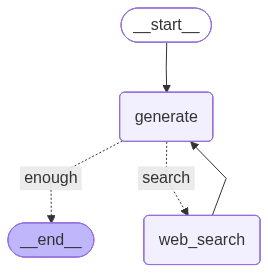

In [8]:
# 그래프 시각화
from IPython.display import display, Image

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"그래프 시각화 실패: {e}")
    print("텍스트로 그래프 구조 출력:")
    print("START → generate → [qa_eval]")
    print("  ├─ enough → END")
    print("  ├─ search → web_search → generate")
    print("  └─ max_reached → END")

## 9. 실행 테스트 (실시간 주가 질문)

### 이론
**실시간 데이터가 필요한 질문**:
- "현재 주가", "최근 동향" 등은 웹 검색이 필수
- 첫 번째 답변은 낮은 점수를 받을 가능성이 높음
- 웹 검색 후 구체적인 수치와 출처가 포함된 답변 생성

**스트림 모드**:
- `graph.stream(state, stream_mode="updates")`: 각 노드의 업데이트를 실시간으로 받음
- 진행 상황을 print문으로 확인 가능

### 코드 설명
- `initial_state`: 초기 상태 정의
  - `query`: 실시간 주가 질문
  - `search_threshold=15`: 15점 이상이면 충분
  - `max_iterations=3`: 최대 3번 반복
- `for update in graph.stream(...)`: 스트림 모드로 실행
- `final_result = graph.invoke(initial_state)`: 최종 결과 실행
- 결과에서 반복 횟수, 평가 점수, 최종 답변 확인

In [9]:
# 실행 테스트
from pprint import pprint

initial_state = {
    'query': '2025년 10월 삼성전자 주식의 현재 주가와 최근 동향을 알려줘',
    'search_threshold': 15,      # 15점 이상이면 충분
    'iteration_count': 0,
    'max_iterations': 3,         # 최대 3번 반복
    'context': [],
    'answer': '',
    'evaluation_score': 0,
    'evaluation_comment': '',
    'error': ''
}

print("="*70)
print("주식 투자 챗봇 - 웹 검색 기반 답변 생성")
print("="*70)
print(f"질문: {initial_state['query']}")
print(f"검색 threshold: {initial_state['search_threshold']}점")
print(f"최대 반복: {initial_state['max_iterations']}회")
print("="*70)

# 스트림 모드로 실행
for update in graph.stream(initial_state, stream_mode="updates"):
    pass  # 각 노드의 print문으로 진행상황 출력

# 최종 결과 실행
final_result = graph.invoke(initial_state)

print("\n" + "="*70)
print("최종 결과")
print("="*70)
print(f"\n총 반복 횟수: {final_result.get('iteration_count', 0)}")
print(f"최종 평가 점수: {final_result.get('evaluation_score', 0)}/20")
print(f"평가 코멘트: {final_result.get('evaluation_comment', 'N/A')}")
print(f"사용된 검색 결과: {len(final_result.get('context', []))}개")
if final_result.get('error'):
    print(f"❌ 에러: {final_result['error']}")

print(f"\n{'='*70}")
print("최종 답변:")
print("="*70)
print(final_result.get('answer', 'N/A'))
print("="*70)

주식 투자 챗봇 - 웹 검색 기반 답변 생성
질문: 2025년 10월 삼성전자 주식의 현재 주가와 최근 동향을 알려줘
검색 threshold: 15점
최대 반복: 3회

[Generate] Iteration 1
Context 개수: 0

[QA Eval] Iteration 1
평가 점수: 12/20
코멘트: 답변은 질문에 대한 직접적인 주가 정보는 제공하지 않지만, 주식 시장의 변동성과 삼성전자의 시장 위치에 대한 일반적인 정보를 포함하고 있습니다. 그러나 구체적인 수치나 실시간 데이터가 없기 때문에 정확성과 완전성에서 점수가 낮습니다. 또한, 명확성과 관련성은 양호하지만, 질문에 대한 직접적인 답변이 부족하여 전체 점수가 낮아졌습니다.
추가 정보 필요: True
🔍 점수가 낮거나 추가 정보가 필요합니다. 웹 검색을 실행합니다.

[Web Search] 검색 쿼리: 2025년 10월 삼성전자 주식의 현재 주가와 최근 동향을 알려줘
✅ 검색 결과 3개 발견
새로운 검색 결과: 3개
총 Context: 3개
  [1] 삼성전자 (005930) - 인베스팅닷컴...
      https://kr.investing.com/equities/samsung-electronics-co-ltd
  [2] 삼성 전자 주가 전망: 2025년, 2026년 - 경제 예측 기관...
      https://wonforecast.com/samsung-electronics
  [3] '9만전자' 맛본 삼성전자...증권가에선 '12만전자' 예상까지 ......
      https://www.mk.co.kr/news/business/11436809

[Generate] Iteration 2
Context 개수: 3

[QA Eval] Iteration 2
평가 점수: 18/20
코멘트: 답변은 질문에 대해 매우 정확하고 상세하게 정보를 제공하고 있습니다. 주가, 거래 범위, 52주 범위, 영업이익 컨센서스 등 구체적인 수치가 포함되어 있어 완전성 또한 높습니다. 명확하게 정리되어 있어 이

## 10. 일반 지식 질문 테스트

### 이론
**일반적인 투자 지식 질문**:
- "분산 투자의 중요성" 같은 질문은 웹 검색 없이도 답변 가능
- LLM의 일반 지식으로 높은 점수를 받을 수 있음
- 하지만 평가 함수가 `needs_more_info=True`를 반환하면 웹 검색 수행

**동적 동작**:
- 같은 그래프가 질문에 따라 다르게 동작
- 실시간 데이터 필요 → 웹 검색
- 일반 지식 → 바로 답변

### 코드 설명
- `simple_state`: 일반 지식 질문
- `graph.invoke(simple_state)`: 그래프 실행
- 반복 횟수와 평가 점수로 동작 확인

In [10]:
# 웹 검색 없이도 답변 가능한 질문 테스트
simple_state = {
    'query': '주식 투자 시 분산 투자의 중요성에 대해 설명해줘',
    'search_threshold': 15,
    'iteration_count': 0,
    'max_iterations': 3,
    'context': [],
    'answer': '',
    'evaluation_score': 0,
    'evaluation_comment': '',
    'error': ''
}

print("\n" + "="*70)
print("일반 투자 지식 질문 테스트 (웹 검색 불필요)")
print("="*70)

simple_result = graph.invoke(simple_state)

print(f"\n최종 평가 점수: {simple_result.get('evaluation_score', 0)}/20")
print(f"반복 횟수: {simple_result.get('iteration_count', 0)}")
print(f"\n답변:\n{simple_result.get('answer', 'N/A')}")


일반 투자 지식 질문 테스트 (웹 검색 불필요)

[Generate] Iteration 1
Context 개수: 0

[QA Eval] Iteration 1
평가 점수: 18/20
코멘트: 답변은 분산 투자의 중요성을 잘 설명하고 있으며, 각 포인트가 명확하게 제시되어 있습니다. 그러나 구체적인 예시나 수치가 부족하여 완전성에서 약간의 점수를 잃었습니다. 또한, 실시간 데이터나 최신 시장 상황에 대한 언급이 없어서 더 나은 이해를 위해 추가 정보가 필요할 수 있습니다.
추가 정보 필요: True
🔍 점수가 낮거나 추가 정보가 필요합니다. 웹 검색을 실행합니다.

[Web Search] 검색 쿼리: 주식 투자 시 분산 투자의 중요성에 대해 설명해줘
✅ 검색 결과 3개 발견
새로운 검색 결과: 3개
총 Context: 3개
  [1] 분산투자, 왜 해야 할까? 포트폴리오 뜻과 분산투자 방법...
      https://kbthink.com/investment/101/diversification.html
  [2] 주식투자 분산투자의 정석(초보 투자자를 위한 분산투자 전략)...
      https://m.blog.naver.com/collera/222000587376
  [3] 주식시장 입문 가이드: 9단계 투자 전략 | EBC Financial Group...
      https://www.ebc.com/kr/forex/244322.html

[Generate] Iteration 2
Context 개수: 3

[QA Eval] Iteration 2
평가 점수: 18/20
코멘트: 답변은 주식 투자 시 분산 투자의 중요성을 잘 설명하고 있으며, 리스크 감소, 평단가 낮추기, 정신적 안정, 다양한 산업에 투자하는 방법 등 여러 측면을 포괄적으로 다루고 있습니다. 각 항목이 명확하게 구분되어 있어 이해하기 쉽고, 관련된 격언과 예시를 통해 설명이 강화되었습니다. 다만, 출처가 구체적으로 명시되지 않아 신뢰성을 높이기 위해 출처를 명확히 하는 것이 좋습니다.
추

## 10. 실습 문제

아래 10개의 문제를 순서대로 풀어보세요. LangGraph와 웹 검색 기반 Agent를 이해하는 데 도움이 됩니다.

In [ ]:
# TODO: AgentState의 필드 이름을 모두 출력하세요
# 힌트: AgentState.__annotations__.keys()를 사용하세요

fields = list(___)  # 빈칸을 채우세요
print("AgentState 필드 목록:")
for field in fields:
    print(f"  - {field}")

# 기대 결과: query, context, answer, search_threshold 등 9개 필드

In [ ]:
# TODO: "테스트 질문"으로 초기 상태를 생성하세요
my_state = {
    'query': ___,  # 빈칸을 채우세요
    'search_threshold': 15,
    'iteration_count': ___,  # 빈칸을 채우세요
    'max_iterations': 3,
    'context': ___,  # 빈칸을 채우세요 (빈 리스트)
    'answer': '',
    'evaluation_score': 0,
    'evaluation_comment': '',
    'error': ''
}

print(f"질문: {my_state['query']}")
print(f"최대 반복: {my_state['max_iterations']}")

# 기대 결과: 질문: 테스트 질문, 최대 반복: 3

In [ ]:
# TODO: 점수 18점, 코멘트 "좋은 답변입니다", needs_more_info=False인 평가 결과 생성
eval_result = EvaledAnswer(
    score=___,  # 빈칸을 채우세요
    comment=___,  # 빈칸을 채우세요
    needs_more_info=___  # 빈칸을 채우세요
)

print(f"점수: {eval_result.score}/20")
print(f"코멘트: {eval_result.comment}")
print(f"추가 정보 필요: {eval_result.needs_more_info}")

# 기대 결과: 점수: 18/20, 코멘트: 좋은 답변입니다, 추가 정보 필요: False

In [ ]:
# TODO: Tavily로 "삼성전자 주가" 검색
search_query = ___  # 빈칸을 채우세요
results = tavily_search_tool.invoke(search_query)

print(f"검색어: {search_query}")
print(f"결과 개수: {len(results)}")
print(f"\n첫 번째 결과:")
print(f"  제목: {results[0].get('title', 'N/A')[:50]}...")
print(f"  URL: {results[0].get('url', 'N/A')}")

# 기대 결과: 3개의 검색 결과와 첫 번째 결과의 제목/URL

In [ ]:
# TODO: 나만의 질문으로 그래프 실행
my_question = ___  # 여기에 질문을 작성하세요

my_test_state = {
    'query': my_question,
    'search_threshold': 15,
    'iteration_count': 0,
    'max_iterations': 2,  # 테스트용으로 2로 설정
    'context': [],
    'answer': '',
    'evaluation_score': 0,
    'evaluation_comment': '',
    'error': ''
}

print(f"질문: {my_question}")
print("="*70)

# 그래프 실행
result = graph.invoke(my_test_state)

print(f"\n최종 답변:")
print(result.get('answer', 'N/A'))
print(f"\n평가 점수: {result.get('evaluation_score', 0)}/20")

# 기대 결과: 질문에 대한 답변과 평가 점수

In [ ]:
# 정답 예시 (주석 해제하여 확인)

# # 문제 1
# fields = list(AgentState.__annotations__.keys())

# # 문제 2
# my_state = {
#     'query': "테스트 질문",
#     'iteration_count': 0,
#     'context': []
# }

# # 문제 3
# response = llm.invoke(question)

# # 문제 4
# eval_result = EvaledAnswer(
#     score=18,
#     comment="좋은 답변입니다",
#     needs_more_info=False
# )

# # 문제 5
# if score >= threshold and not needs_more_info:

# # 문제 6
# return iteration >= max_iter

# # 문제 7
# search_query = "삼성전자 주가"

# # 문제 8
# updated_context = existing_context + new_results

# # 문제 9
# test_graph = StateGraph(AgentState)
# test_graph.add_node("my_node", my_node)

# # 문제 10
# my_question = "주식 투자의 기본 원칙 3가지는?"

---

## 정답 확인

모든 문제를 풀었다면, 아래 셀의 주석을 해제하여 정답을 확인할 수 있습니다.

### 문제 10: 나만의 워크플로우 만들기

**목표**: 간단한 질문을 만들고 그래프를 실행하여 답변을 받아보세요.

**힌트**: 
- `initial_state`를 만들고 `graph.invoke()`로 실행하세요.
- 웹 검색이 필요 없는 일반적인 질문을 선택하면 더 빠릅니다.

**추천 질문 예시**:
- "주식 투자의 기본 원칙 3가지는?"
- "분산 투자가 중요한 이유는?"
- "장기 투자와 단기 투자의 차이점은?"

### 문제 9: StateGraph 노드 추가하기

**목표**: StateGraph에 새로운 노드를 추가하는 코드를 작성하세요.

**힌트**: `add_node()` 메서드를 사용하세요.

In [ ]:
# TODO: 새로운 StateGraph 생성하고 노드 추가
from langgraph.graph import StateGraph

# 간단한 노드 함수 정의
def my_node(state: AgentState) -> AgentState:
    \"\"\"간단한 노드 함수\"\"\"
    print("my_node 실행!")
    return {"answer": "노드 테스트"}

# StateGraph 생성
test_graph = StateGraph(___)  # 빈칸을 채우세요 (AgentState)

# 노드 추가
test_graph.add_node(___, my_node)  # 빈칸을 채우세요 ("my_node")

print("✅ StateGraph 생성 및 노드 추가 완료")

# 기대 결과: ✅ StateGraph 생성 및 노드 추가 완료

### 문제 8: Context 누적 이해하기

**목표**: 기존 context에 새로운 검색 결과를 누적하는 로직을 작성하세요.

**힌트**: 리스트 합치기(`+`)를 사용하세요.

In [ ]:
# TODO: Context 누적 로직 완성
existing_context = [{"title": "결과1", "url": "http://example.com/1"}]
new_results = [
    {"title": "결과2", "url": "http://example.com/2"},
    {"title": "결과3", "url": "http://example.com/3"}
]

# 기존 context에 새 결과 추가
updated_context = existing_context ___ new_results  # 빈칸을 채우세요 (+)

print(f"기존 context: {len(existing_context)}개")
print(f"새 결과: {len(new_results)}개")
print(f"누적 context: {len(updated_context)}개")

# 기대 결과: 기존 context: 1개, 새 결과: 2개, 누적 context: 3개

### 문제 7: Tavily 검색 API 사용하기

**목표**: Tavily API로 "삼성전자 주가"를 검색하세요.

**힌트**: `tavily_search_tool.invoke()` 메서드를 사용하세요.

### 문제 6: 조건부 로직 작성하기

**목표**: 최대 반복 횟수를 체크하는 로직을 작성하세요.

**힌트**: `iteration_count`와 `max_iterations`를 비교하세요.

In [ ]:
# TODO: 최대 반복 횟수 체크 함수 완성
def check_max_iterations(iteration: int, max_iter: int) -> bool:
    """최대 반복 횟수에 도달했는지 확인"""
    return iteration >= ___  # 빈칸을 채우세요

# 테스트
print(check_max_iterations(3, 3))  # True
print(check_max_iterations(2, 3))  # False
print(check_max_iterations(4, 3))  # True

# 기대 결과: True, False, True

### 문제 5: 평가 점수 이해하기

**목표**: 점수에 따라 다음 행동을 결정하는 조건문을 작성하세요.

**힌트**: `search_threshold`와 비교하세요.

In [ ]:
# TODO: 점수에 따라 행동을 결정하는 함수 완성
def decide_action(score: int, threshold: int, needs_more_info: bool) -> str:
    """점수와 threshold를 비교하여 다음 행동 결정"""
    if score >= ___ and not needs_more_info:  # 빈칸을 채우세요
        return "enough"  # 충분함, 종료
    else:
        return "search"  # 검색 필요

# 테스트
print(decide_action(18, 15, False))  # "enough"
print(decide_action(12, 15, False))  # "search"
print(decide_action(18, 15, True))   # "search"

# 기대 결과: enough, search, search

### 문제 4: Pydantic으로 구조화된 출력 만들기

**목표**: `EvaledAnswer` 클래스를 사용하여 구조화된 평가 결과를 생성하세요.

**힌트**: Pydantic 모델 인스턴스를 직접 생성하세요.

### 문제 3: LLM으로 답변 생성하기

**목표**: `ChatOpenAI`를 사용하여 간단한 질문에 답변을 생성하세요.

**힌트**: `llm.invoke()` 메서드를 사용하세요.

In [ ]:
# TODO: "주식 투자란 무엇인가요?" 질문에 대한 답변 생성
question = "주식 투자란 무엇인가요?"
response = llm.invoke(___)  # 빈칸을 채우세요

print(f"질문: {question}")
print(f"답변: {response.content[:100]}...")  # 처음 100자만 출력

# 기대 결과: LLM이 생성한 주식 투자에 대한 설명

### 문제 2: 간단한 State 생성하기

**목표**: 초기 `AgentState`를 딕셔너리로 생성하세요.

**힌트**: 위의 `initial_state` 예시를 참고하세요.

### 문제 1: AgentState 타입 이해하기

**목표**: `AgentState`에 어떤 필드들이 있는지 확인하고, 각 필드의 역할을 이해하세요.

**힌트**: `AgentState` 클래스 정의를 다시 읽어보세요.